# Experiment N°001 - Pitch shrinking

In [2]:
import IPython.display as idisplay
import numpy as np 
import matplotlib.pyplot as plt

import librosa

In [3]:
G4_SINE = librosa.load('./data/G4_triad-sine_synth.wav', mono=True, sr=None)
G4_PIANO = librosa.load('./data/G4_triad-Upright_synth.wav', mono=True, sr=None)
SPEECH = librosa.load('./data/bbawtd.wav', mono=True, sr=None)

We have 3 audio sample, 2 G4 triad one made with pure sines and the other with a piano soundfont, and 1 neutral speech sample.

At first, we'll focus on the G4 samples as we know what we should expect from the pitch shrinking. e.g. with the reference pitch
set to G4 and a shriking of 0.5 the G4 triad (G4, B4, D5) will become G4, ~A4, ~B4.

In [4]:
# Change this to process another sample
wavform, sr = G4_SINE

In [114]:
win_len = 4096
n_fft = 4096
hop_len = 1024
anls_stft = librosa.stft(wavform, n_fft=n_fft, hop_length=hop_len, win_length=win_len)
n_anls_freqs, n_anls_frames = anls_stft.shape
print(anls_stft.shape)

(2049, 94)


In [115]:
def spectrogram(data):
  D = librosa.stft(data, hop_length=hop_len, n_fft=n_fft, win_length=win_len)
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

  fig, ax = plt.subplots()
  img = librosa.display.specshow(
    S_db, 
    x_axis='time', y_axis='log',
    hop_length=hop_len, n_fft=n_fft, win_length=win_len,
    ax=ax, sr=sr)
  ax.set(title='Spectrogram')
  fig.colorbar(img, ax=ax, format="%+2.f dB")

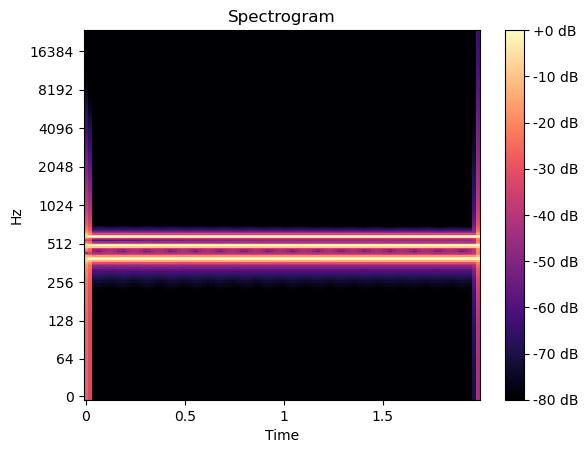

In [116]:
idisplay.display(idisplay.Audio(wavform, rate=sr))
spectrogram(wavform)

In [117]:
def interpolate_freq(idxs: np.ndarray, arr):
    start = idxs.astype(int)
    frac = (idxs - start)[:, None]
    shifted_arr = np.concatenate((arr[1:, :], np.zeros((1, arr.shape[1]))), axis=0)
    return arr[start, :] * (1 - frac) + shifted_arr[start, :] * frac

In [134]:
shrinkage = .75
ref_freq = 392.0 #G4
ref_freq_id = ref_freq / ((sr / 2) / (n_anls_freqs - 1))
anls_freqs = np.arange(n_anls_freqs)
n_synth_freqs = n_anls_freqs

og_idxs = (np.arange(n_synth_freqs).astype(float) - ref_freq_id) / shrinkage + ref_freq_id
og_idxs[0] = 0

n_below_min_freq = len(og_idxs[og_idxs < 0])
n_above_max_freq = len(og_idxs[og_idxs > (n_anls_freqs - 1)])
og_idxs = og_idxs[~((og_idxs < 0) | (og_idxs > (n_anls_freqs - 1)))]

synth_freqs = np.arange(len(og_idxs))

aligned_phase_diff = np.pi * 2 * hop_len / win_len

mags = np.abs(anls_stft)
phases = np.angle(anls_stft)

phase_diffs = phases - np.concatenate((np.zeros((n_anls_freqs, 1)), phases[:, :-1]), axis=1)
phase_diffs -= (anls_freqs * aligned_phase_diff)[:, None]
phase_diffs = np.mod(phase_diffs + np.pi, np.pi * 2) - np.pi

shifted_mags = interpolate_freq(og_idxs, mags)
shifted_phase_diffs = interpolate_freq(og_idxs, phase_diffs) * shrinkage

shifted_phase_diffs += (synth_freqs * aligned_phase_diff)[:, None]

shifted_phases = np.cumsum(shifted_phase_diffs, axis=1)

synth_stft = shifted_mags * np.exp(shifted_phases * 1j)
# padding the missing frequencies
synth_stft = np.concatenate(
  (np.zeros((n_below_min_freq, n_anls_frames)), synth_stft, np.zeros((n_above_max_freq, n_anls_frames))),
  axis=0)

new_waveform = librosa.istft(synth_stft, hop_length=hop_len, win_length=win_len, n_fft=n_fft)

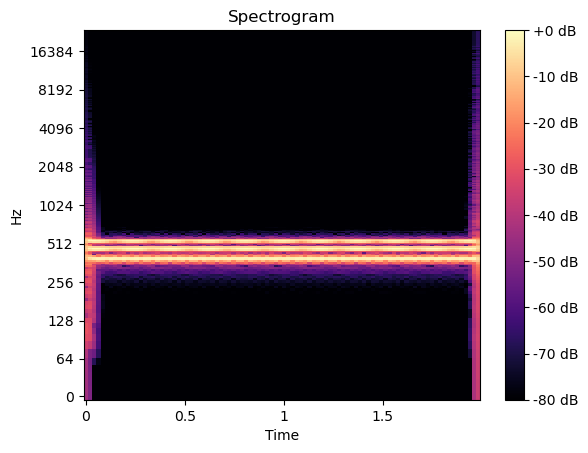

In [135]:
idisplay.display(idisplay.Audio(new_waveform, rate=sr))
spectrogram(new_waveform)

> These results are promising. The pitches are getting closer to the designated reference pitch. However flutter is noticeable on the pitches being shifted up. As phases are not currently accounted for this is most likely where the issue arises. 

2025/02/09